In [111]:
import collections
import math
import os
import random
import zipfile

In [112]:
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

In [113]:
print(np.__version__)
print(tf.__version__)

1.22.3
2.8.0


In [114]:
# DOWNLOAD DATA
DOWNLOADED_FILENAME = 'SampleText.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
        
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)
        raise Exception('Fialed to verift file fromL ' + url_path)

In [115]:
# EXTRACT WORDS
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
        
    return words

In [116]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


In [151]:
vocabulary = read_words()

In [152]:
len(vocabulary)

17005207

In [153]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

In [154]:
# BUILD AND PREPARE DATASET
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
    
    dictionary = dict()
    
    for word, _ in word_counts:
        # create word and index
        dictionary[word] = len(dictionary)
        
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 # dictionary['UNKNOWN']
            unknown_count += 1
            
        word_indexes.append(index)
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return word_counts, word_indexes, dictionary, reversed_dictionary

In [155]:
VOCABULARY_SIZE = 10000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(
vocabulary, VOCABULARY_SIZE)

In [156]:
word_counts[:10]

[['UNKNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [157]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [158]:
import random

for key in random.sample(sorted(dictionary), 10):
    print(key, ":", dictionary[key])

competitive : 4154
plate : 3255
saving : 6457
instantly : 9934
spellings : 9649
floppy : 4947
antarctica : 6362
vowel : 2638
cancelled : 6038
coaches : 8593


In [159]:
del vocabulary

In [160]:
# GENERATE TRAINING BATCHES
# Global index into words maintained across batches
global_index = 0

def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 # [skip_window input_word skip_window]
    
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    for i in range(batch_size // num_skips):
        target = skip_window # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
                
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window] # this is the input word
            labels[i * num_skips + j, 0] = buffer[target] # these are the context words
            
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    
    return batch, labels

In [161]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [162]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156],
      dtype=int32)

In [163]:
labels

array([[  59],
       [3081],
       [ 156],
       [   2],
       [ 742],
       [  59],
       [ 156],
       [ 742],
       [ 134],
       [3134]], dtype=int32)

In [164]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]])

of :  used
of :  originated
abuse :  against
abuse :  of
first :  working
first :  used
used :  against
used :  working
against :  including


In [165]:
# CONSTRUCT THE NEURAL NETWORK
# reset the global index because we updated while testing the batch code
global_index = 0

In [166]:
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [167]:
num_samples = 64 # number of corrupted sample pairs to feed into the NCE

In [168]:
batch_size = 128 # number or words and their corresponding targets per iteration
embedding_size = 50 # number of dimensions our word embeddings will have (hidden layer has x neurons)
skip_window = 2
num_skips = 2

In [169]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [170]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [171]:
embeddings = tf.Variable(
    tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))

embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [172]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32_ref>

In [173]:
embed

<tf.Tensor 'embedding_lookup/Identity:0' shape=(128, 50) dtype=float32>

In [174]:
nce_weights = tf.Variable(
    tf.truncated_normal([VOCABULARY_SIZE, embedding_size],
                       stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [175]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                  biases=nce_biases,
                  labels=train_labels,
                  inputs=embed,
                  num_sampled=num_samples,
                  num_classes=VOCABULARY_SIZE))

In [176]:
optimiser = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [177]:
# TRAIN THE NEURAL NETWORK
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))

normalised_embeddings = embeddings / l2_norm

In [178]:
valid_embeddings = tf.nn.embedding_lookup(normalised_embeddings, valid_dataset)

In [179]:
similarity = tf.matmul(valid_embeddings, normalised_embeddings, transpose_b=True)

In [180]:
init = tf.global_variables_initializer()

In [181]:
num_steps = 200001

In [182]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
        word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimiser, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
            
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbours
                
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s: ' % valid_word
                
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
            
    final_embeddings = normalised_embeddings.eval()

Average loss at step  0 :  228.8582763671875
Nearest to also:  wherein, fritz, afterwards, trade, weakness, academic, beads, represent,
Nearest to only:  gothic, identical, representing, freed, strictly, riemann, himself, combined,
Nearest to time:  simultaneously, efficiency, handling, candidates, spam, rapper, distinguishing, hal,
Nearest to first:  uk, junta, insert, defines, pdf, beaches, ben, parameter,
Nearest to and:  arena, the, dissolution, duplicate, contributed, signal, tokyo, loyalty,
Nearest to s:  sides, sex, physical, associate, careful, orbital, coupled, unlike,
Nearest to used:  intermediate, register, ludwig, franchise, nelson, ic, pan, ahmad,
Nearest to on:  french, scripts, stations, secrets, quasi, dive, dia, registry,
Nearest to up:  viewpoint, copies, clapton, wanted, edmund, broadway, believes, mile,
Nearest to many:  oriental, boolean, seasonal, ram, eusebius, excellent, attraction, peel,
Nearest to there:  hop, spectral, taken, printed, explicit, intensity, ge

Average loss at step  52000 :  5.3921874322891234
Average loss at step  54000 :  5.414694193482399
Average loss at step  56000 :  5.435833662509919
Average loss at step  58000 :  5.354781976342201
Average loss at step  60000 :  5.284745888113975
Nearest to also:  at, beads, academic, terms, trade, roger, founder, represent,
Nearest to only:  himself, identical, house, facts, appeared, combined, representing, october,
Nearest to time:  union, hydrogen, candidates, algebra, pope, character, atom, austrian,
Nearest to first:  uk, dutch, video, language, pdf, know, understanding, at,
Nearest to and:  UNKNOWN, in, of, to, from, the, by, for,
Nearest to s:  and, sides, church, sex, in, history, apply, unlike,
Nearest to used:  failed, straight, described, agave, register, senate, linear, reign,
Nearest to on:  french, na, in, of, nerve, for, UNKNOWN, include,
Nearest to up:  million, higher, wanted, deaths, copies, english, outer, provided,
Nearest to many:  ram, boolean, electrical, manner,

Average loss at step  112000 :  4.8712371460199355
Average loss at step  114000 :  4.889020741939545
Average loss at step  116000 :  4.822094675302505
Average loss at step  118000 :  4.8489008674621585
Average loss at step  120000 :  4.805924621582031
Nearest to also:  roger, fritz, induced, academic, beads, tallest, at, organisms,
Nearest to only:  identical, house, himself, facts, appeared, combined, representing, alfred,
Nearest to time:  union, candidates, hydrogen, efficiency, simultaneously, revolt, austrian, atom,
Nearest to first:  uk, dutch, understanding, video, pdf, enables, junta, insert,
Nearest to and:  from, w, UNKNOWN, poland, or, trial, with, identical,
Nearest to s:  sex, history, ink, and, sides, apply, publish, unlike,
Nearest to used:  straight, failed, linear, memory, register, ahmad, recently, described,
Nearest to on:  french, in, nerve, na, for, twelve, guidance, with,
Nearest to up:  million, wanted, copies, obligations, higher, dvd, evolved, outer,
Nearest to

Average loss at step  172000 :  4.767103066682815
Average loss at step  174000 :  4.740080425977707
Average loss at step  176000 :  4.7821699595451355
Average loss at step  178000 :  4.755930010795593
Average loss at step  180000 :  4.77053825378418
Nearest to also:  fritz, roger, induced, tallest, barcelona, torture, organisms, license,
Nearest to only:  identical, appeared, facts, himself, house, combined, gothic, representing,
Nearest to time:  efficiency, revolt, equally, attempting, candidates, hydrogen, pressures, union,
Nearest to first:  dutch, uk, enables, understanding, insert, video, diverse, pdf,
Nearest to and:  w, or, poland, from, trial, signal, display, with,
Nearest to s:  sex, ink, history, sides, apply, and, physical, provides,
Nearest to used:  straight, failed, memory, linear, recently, attributes, ahmad, intersection,
Nearest to on:  french, in, nerve, na, bold, twelve, millennium, commonly,
Nearest to up:  wanted, obligations, viewpoint, dvd, copies, outer, evolv

In [184]:
def save_word_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
    
save_word_embeddings(final_embeddings, word_counts)

In [188]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize=(18, 18)) # in inches
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x, y)
        
        plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.savefig(filename)
    plt.show(filename)

In [189]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

/home/tim/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/tim/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


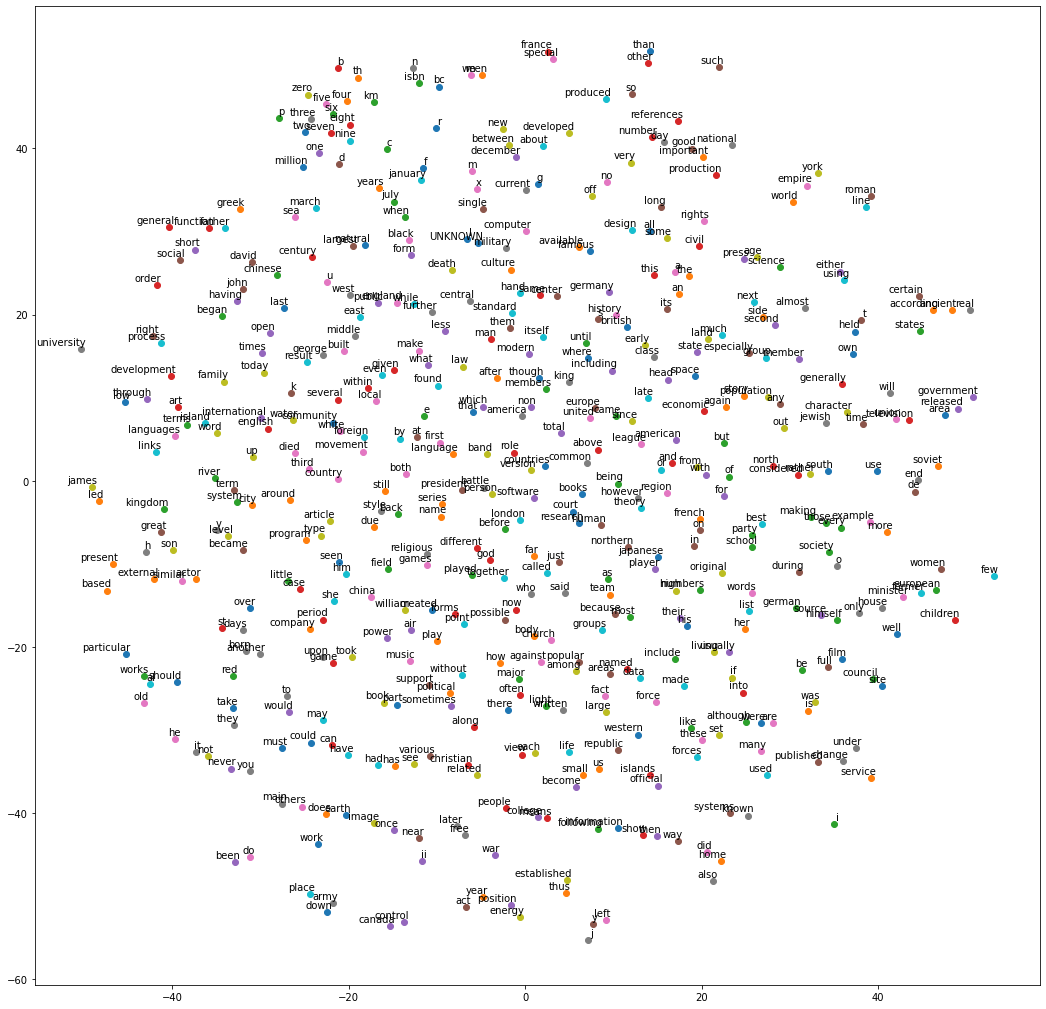

In [190]:
plot_with_labels(low_dim_embs, labels)